### 从零开始搭建神经网络

之前我们用RNN模型对时间序列数据做预测，直接用到了深度神经网络的模型结构。下面的实验将从零开始搭建神经网络，逐步增加模型的复杂度，比较模型效果提升的情况。

### 数据预处理

之前的实验里，我们都用了沪深300指数作为样本数据，这次实验我们选用个股科大讯飞（002230.SZ）。第一步还是导入股票的历史行情数据（前复权）。

In [1]:
import akshare as ak
ticker = 'sz002230'
sz002230_daily = ak.stock_zh_a_daily(symbol=ticker, start_date="20100101", end_date="20250101", adjust="qfq")
sz002230_close = sz002230_daily.close
sz002230_date = sz002230_daily.date
sz002230_close.shape

(2910,)

我们先看下收盘价对应的走势图。

In [2]:
from pylab import plt, mpl

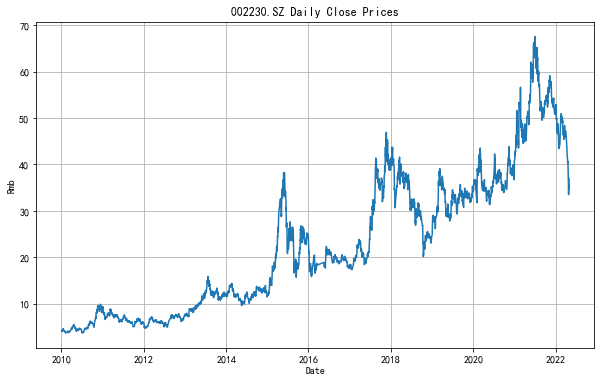

In [3]:
x = sz002230_date
y = sz002230_close
plt.figure(figsize=(10, 6))
plt.plot(x,y)
plt.title('002230.SZ Daily Close Prices')
plt.ylabel('Rmb')
plt.xlabel('Date')
plt.grid()

我们计划用过去1个月，即每22个交易日的数据预测第23个交易日的值，这里用n_steps=22定义，并将原始收盘价拆分成若干个这样的序列组合。

In [4]:
import numpy as np
import pandas as pd

In [5]:
def split_sequence(sequence,n_steps):
    x, y = [], []
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        x.append(seq_x)
        y.append(seq_y)
    return np.array(x), np.array(y)

In [6]:
n_steps = 5
dimensionality = 1

In [7]:
x_sz002230, y_sz002230 = split_sequence(sz002230_close, n_steps)

In [8]:
x_sz002230 = x_sz002230.reshape((x_sz002230.shape[0], x_sz002230.shape[1], dimensionality))
y_sz002230 = y_sz002230.reshape(len(y_sz002230),-1)

In [9]:
x_sz002230.shape

(2905, 5, 1)

In [10]:
y_sz002230.shape

(2905, 1)

这里需要注意，我们将输入变量x转变为了三维数据结构【batch size, time steps, dimensionality】，这里dimensionality = 1代表我们处理的是时间序列是单变量时间序列，即：univariate time series。换言之，每个时间点t，只对应1个值。

In [12]:
sz002230_close[0:6]

0    4.08
1    4.17
2    4.16
3    4.01
4    4.14
5    4.30
Name: close, dtype: float64

In [13]:
x_sz002230[0]

array([[4.08],
       [4.17],
       [4.16],
       [4.01],
       [4.14]])

In [14]:
y_sz002230[0]

array([4.3])

从上面第一个batch显示的结果看，我们的拆分是成功的。下面要将全量数据进一步分为training、validation和test集合。

In [16]:
split1 = int((x_sz002230.shape[0])*0.80)
split2 = int((x_sz002230.shape[0])*0.90)
x_train, y_train = x_sz002230[:split1,:n_steps], y_sz002230[:split1,-1]
x_valid, y_valid = x_sz002230[split1:split2,:n_steps], y_sz002230[split1:split2,-1]
x_test, y_test = x_sz002230[split2:,:n_steps], y_sz002230[split2:,-1]

In [17]:
y_train = y_train.reshape(len(y_train),-1)
y_valid = y_valid.reshape(len(y_valid),-1)
y_test = y_test.reshape(len(y_test),-1)

In [18]:
x_train.shape

(2324, 5, 1)

In [19]:
y_train.shape

(2324, 1)

In [20]:
x_valid.shape

(290, 5, 1)

In [21]:
y_valid.shape

(290, 1)

In [22]:
x_test.shape

(291, 5, 1)

In [23]:
y_test.shape

(291, 1)

### 基准值

数据预处理完成后，我们可以先指定一个基准值。设定基准值的好处，是回答<u>“猴子都能选股”</u>的问题。别小看“猴子”的能力，我们训练的模型是否能超过盲选的结果？在时间序列预测里，我们用最近一个值代替预测值，就是我们用第5天的值，作为第6值的预测值。

In [74]:
from keras.models import Sequential
from keras.layers import SimpleRNN, LSTM, Dense, Flatten, Dropout
from tensorflow import keras

上面的预测给出了我们错误率（Mean Squared Error）大概是1.83的结果。

In [26]:
y_pred = x_test[:, -1]
np.mean(keras.losses.mean_squared_error(y_test, y_pred))

1.8234309278350518

In [27]:
model = Sequential()
model.add(Flatten(input_shape=[n_steps, 1]))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 5)                 0         
                                                                 
 dense (Dense)               (None, 1)                 6         
                                                                 
Total params: 6
Trainable params: 6
Non-trainable params: 0
_________________________________________________________________


In [29]:
%%time
model.fit(x_train, y_train, epochs=20, validation_data=(x_valid, y_valid), verbose=False)

CPU times: total: 2.16 s
Wall time: 2.27 s


In [30]:
y_pred = model.predict(x_test)
np.mean(keras.losses.mean_squared_error(y_test, y_pred))

37.764835

In [31]:
model = Sequential()
model.add(SimpleRNN(1, input_shape=[None, 1]))
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 1)                 3         
                                                                 
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [33]:
%%time
model.fit(x_train, y_train, epochs=20, validation_data=(x_valid, y_valid), verbose=False)

CPU times: total: 3.62 s
Wall time: 3.06 s


In [34]:
y_pred = model.predict(x_test)
np.mean(keras.losses.mean_squared_error(y_test, y_pred))

2658.0771

In [35]:
model = Sequential()
model.add(SimpleRNN(20, return_sequences=True, input_shape=[None, 1]))
model.add(SimpleRNN(20))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [36]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, None, 20)          440       
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 20)                820       
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________


In [37]:
%%time
model.fit(x_train, y_train, epochs=200, validation_data=(x_valid, y_valid), verbose=False)

CPU times: total: 1min 11s
Wall time: 28.3 s


In [38]:
y_pred = model.predict(x_test)
np.mean(keras.losses.mean_squared_error(y_test, y_pred))

101.04569

In [47]:
model = Sequential()
model.add(LSTM(256, activation='relu', input_shape=(n_steps, 1)))
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [48]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 256)               264192    
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 264,449
Trainable params: 264,449
Non-trainable params: 0
_________________________________________________________________


In [43]:
%%time
model.fit(x_train, y_train, epochs=500, validation_data=(x_valid, y_valid), verbose=False)

CPU times: total: 1h 24min 27s
Wall time: 12min 44s


In [45]:
y_pred = model.predict(x_test)
np.mean(keras.losses.mean_squared_error(y_test, y_pred))

5.752725

In [69]:
model = Sequential()
model.add(LSTM(256, activation='relu', input_shape=(n_steps, 1)))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [70]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 256)               264192    
                                                                 
 dense_17 (Dense)            (None, 128)               32896     
                                                                 
 dense_18 (Dense)            (None, 1)                 129       
                                                                 
Total params: 297,217
Trainable params: 297,217
Non-trainable params: 0
_________________________________________________________________


In [81]:
%%time
model.fit(x_train, y_train, epochs=1000, validation_data=(x_valid, y_valid), verbose=False)

CPU times: total: 15h 18min 40s
Wall time: 1h 36min 55s


In [82]:
y_pred = model.predict(x_test)
np.mean(keras.losses.mean_squared_error(y_test, y_pred))

65.71387

In [75]:
model = Sequential()
model.add(LSTM(512, activation='relu', input_shape=(n_steps, 1), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(256, activation='relu'))
model.add(Flatten())
model.add(Dense(1, activation='linear'))
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

In [76]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 5, 512)            1052672   
                                                                 
 dropout (Dropout)           (None, 5, 512)            0         
                                                                 
 lstm_8 (LSTM)               (None, 256)               787456    
                                                                 
 flatten_1 (Flatten)         (None, 256)               0         
                                                                 
 dense_19 (Dense)            (None, 1)                 257       
                                                                 
Total params: 1,840,385
Trainable params: 1,840,385
Non-trainable params: 0
_________________________________________________________________


In [79]:
%%time
model.fit(x_train, y_train, epochs=1000, validation_data=(x_valid, y_valid), verbose=False)

CPU times: total: 14h 32min 10s
Wall time: 1h 26min 46s


In [80]:
y_pred = model.predict(x_test)
np.mean(keras.losses.mean_squared_error(y_test, y_pred))

53.981873